To setup the environment run the following commands on kaggle

In [59]:
!cp /kaggle/input/a3-1-1/A3/environment.yml /kaggle/working/
!cp /kaggle/input/a3-1-1/A3/install.sh /kaggle/working/

!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


Run your .py file on CLI using the following command

In [ ]:
!python bird.py path_to_dataset train bird.pth

In [ ]:
!python bird.py path_to_dataset test bird.pth

# Models to be tested

### Preprocessing
  1) Load Images as tensors
  2) Transform the images
     - Padding
     - Cropping
     - Resize-ing
  3) Continue with model Preparation
  4) Scale the images
  5) Normalize the images

### Model Training

- Normal Architecture with EffNet scaling laws
  > Compound Scaling Method
- Learning Rate Schedulers
  1) `CyclicLR`
  2) `OneCylceLR`
  3) Try Learning Rate WarmUp
- Add BatchNorm
- Scale the network
- Add Skip Connections
- Scale the network
- Try ResNet Like Architecture
- Try GoogleNet like Architecture
- Try Data Augmentation
  1) Random Cropping
  2) Flipping and turning
  3) Brightness/contrast adjustments
  4) Aspect Ratio Jitter
  5) Colour Jitter
  6) `Albumentations`
  7) Try Adaptive Augmentation Methods
- Try Removing Classimbalance by
  1) Data Augmentation + OverSampling
  2) Weighted Classification
  3) Focal Loss
- Try Label Smoothing
- Try DropBlock and DropOut see which is better
- Check for Gradient Clipping 

### Model Callibration

- Try Model Calibration
  1) Temperature Scaling for Calibration
  2) Calbration with Brier Score
 
### Visualization and Debugging

- Grad-CAM
- TensorBoard
- Weights and Biases
- Update Ratios

In [60]:
!pip list | grep pandas & pip list | grep numpy

geopandas                                0.14.4
numpy                                    1.26.4
pandas                                   2.2.3
pandas-datareader                        0.10.0
pandas-profiling                         3.6.6
pandas-summary                           0.2.0
pandasql                                 0.7.3
sklearn-pandas                           2.2.0


# Train and Test Loaders

In [61]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors

In [62]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the subfolders (0, 1, ..., 9).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate over each subdirectory (0, 1, ..., 9)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Loading Data

In [63]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [64]:
root_dir = "/kaggle/input/identify-the-birds/Birds"
train_dir = os.path.join(root_dir, "train")

dataset = ImageDataset(root_dir=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1)

# EDA

torch.Size([1, 3, 900, 1200])


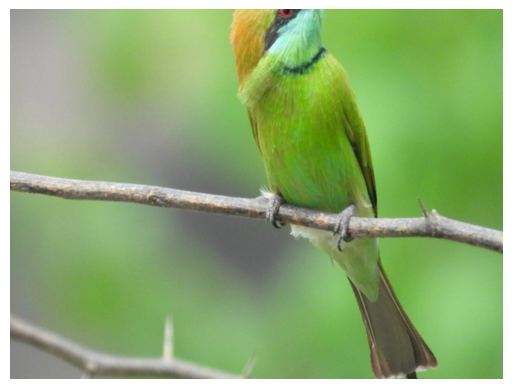

torch.Size([1])
0
torch.Size([1, 3, 750, 1200])


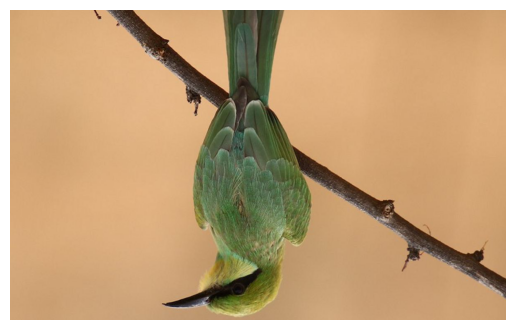

torch.Size([1])
1
torch.Size([1, 3, 719, 1200])


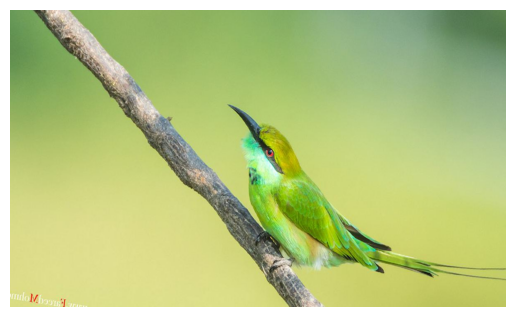

torch.Size([1])
2
torch.Size([1, 3, 900, 1200])


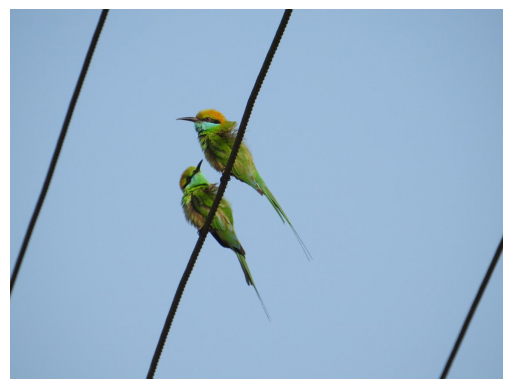

torch.Size([1])
3
torch.Size([1, 3, 839, 1200])


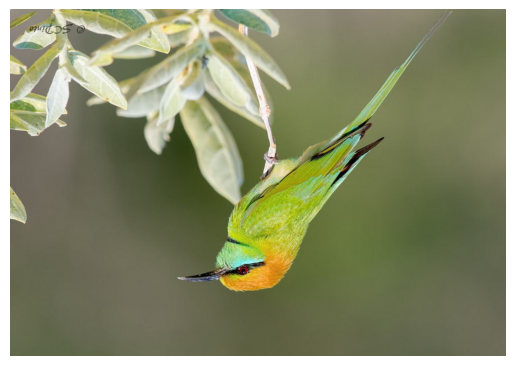

torch.Size([1])
4
torch.Size([1, 3, 1200, 962])


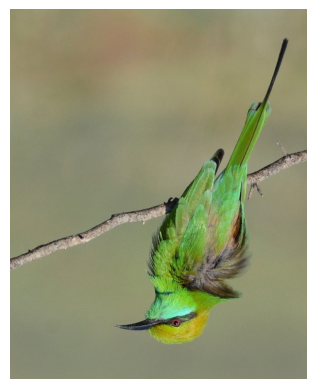

torch.Size([1])
5
torch.Size([1, 3, 675, 1200])


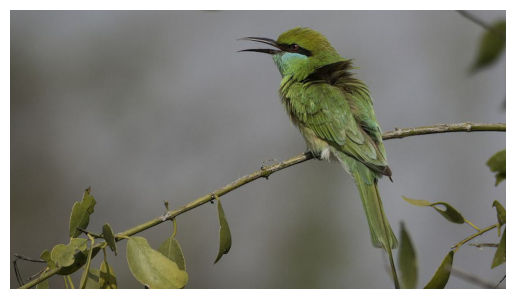

torch.Size([1])
6


In [65]:
for idx, (images, labels) in enumerate(dataloader):
    print(images.shape)

    # printing the image to see
    image_numpy = images[0].permute(1, 2, 0).numpy()
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()
    
    print(labels.shape)
    print(idx)
    if (idx > 5):
        break

In [66]:
# Initialize an empty counter
label_counts = Counter()

# Iterate over the batches in the dataloader
for images, labels in dataloader:
    # Update the counter with all labels in the current batch
    label_counts.update(labels.tolist())

# Convert to DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count']).sort_index()

print(label_df)

   Count
0   1080
1    960
2    720
3    840
4   1200
5   1200
6   1200
7    960
8    960
9    840


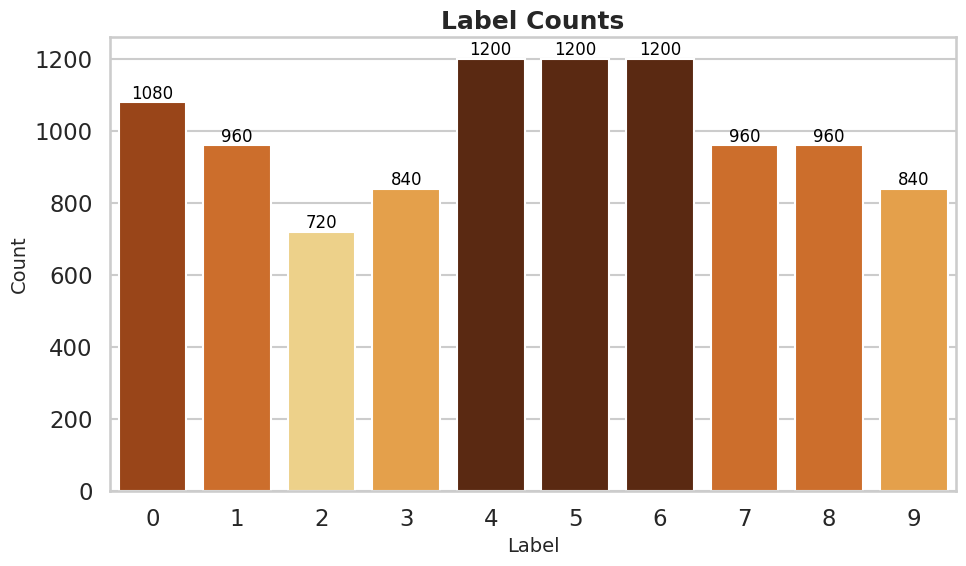

In [67]:
# Data
data = {'Label': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        'Count': [1080, 960, 720, 840, 1200, 1200, 1200, 960, 960, 840]}

df = pd.DataFrame(data)

# Normalize the color scale based on the 'Count' column
norm = mcolors.Normalize(vmin=min(df['Count'])-200, vmax=max(df['Count']))

# Create the color palette (e.g., 'YlOrBr' palette) and map it to the counts
colors = sns.color_palette("YlOrBr", as_cmap=True)(norm(df['Count']))

# Set the plot style and context using seaborn for a clean look
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Label', y='Count', data=df, palette=colors)

# Add labels and title
bar_plot.set_title('Label Counts', fontsize=18, fontweight='bold')
bar_plot.set_xlabel('Label', fontsize=14)
bar_plot.set_ylabel('Count', fontsize=14)

# Show the counts on top of the bars
for index, value in enumerate(df['Count']):
    bar_plot.text(index, value + 10, f'{value}', color='black', ha="center", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()